### COVID Excess Savings by Holder Revisited

Census Consumer Expenditure data combined with BEA personal income data


Updated November 10, 2022

In [6]:
import pandas as pd

data_dir = '/home/brian/Documents/uschartbook/chartbook/data/'

In [8]:
# Full CE table from BLS
file = 'ce_full.csv'
df = pd.read_csv(data_dir + file)

# Variables to keep
cats = ['CONSUNIT', 'TOTALEXP', 'INCAFTTX', 'PENSIONS']

# Income Quintiles: 1 is overall, 2 is bottom, 4 middle, 6 top. 
grps = [1, 2, 3, 4, 5, 6]

results, sh = pd.DataFrame(), pd.DataFrame()
# Clean up the selected data for each quintile group and variable
for grp in grps:
    for cat in cats:
        srs = f'CXU{cat}LB010{grp}M'
        data = (df.loc[df.series_id == srs]
                  .set_index('year')['value']
                  .astype('int'))
        name = f'{cat}_{grp}'
        results[name] = data
    # Expenditures exclude spending on pensions (a form of saving)    
    exp = (results[f'TOTALEXP_{grp}'] - results[f'PENSIONS_{grp}'])
    results[f'ADJEXP_{grp}'] = exp
results.index = [f'{yr}-07-01' for yr in results.index] # Date index

# Calculate share of total held by each quintile
for grp in [2, 3, 4, 5, 6]:
    for cat in ['ADJEXP', 'INCAFTTX']:
        gsh = results[f'{cat}_{grp}'] * results[f'CONSUNIT_{grp}']
        tot = results[f'{cat}_1'] * results[f'CONSUNIT_1']
        sh[f'{cat}_{grp}'] = (gsh / tot)
    
# Projection for 2022 annual CE data based on latest (80%)
# previous (10%) and long-term average (10%)
tmp = ((sh.mean() * (0.1)) + (sh.iloc[-1] * (0.8)) 
       + (sh.iloc[-2] * (0.1))).to_frame().T
tmp.index = ['2022-12-01']
tmp.index.name = 'date'
sh = pd.concat([sh, tmp])
sh.index = [pd.to_datetime(dt) for dt in sh.index]
shm = sh.resample('MS').interpolate(method='cubic', 
                              fill_value='extrapolate')

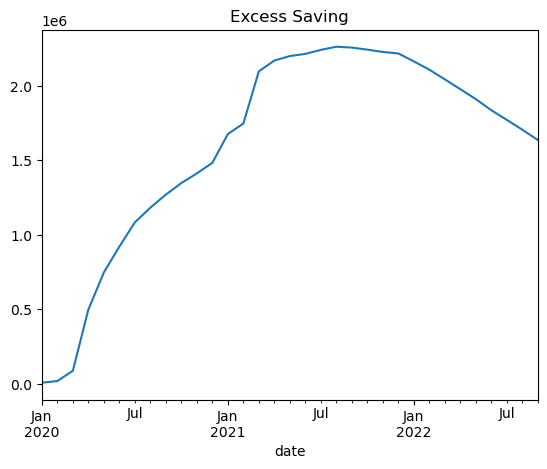

In [9]:
# Collect data and show overall excess saving
inc = pd.read_csv(data_dir + 'nipa20600.csv', 
                 index_col='date', parse_dates=True)
pce = pd.read_csv(data_dir + 'nipaU20405.csv', 
                 index_col='date', parse_dates=True)
exp = pce['DPCERC']
dpi = inc['A067RC']
sv = dpi - exp

val2019 = (sv.resample('AS').mean()).loc['2019-01-01']
# Excess as the difference from the 2019 rate
excess_saving = ((sv.loc['2020-01-01':] - val2019) / 12).cumsum()
excess_saving.plot(title = "Excess Saving");

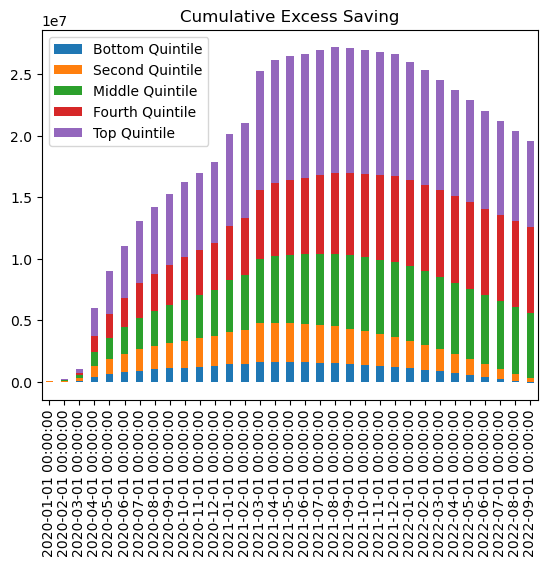

In [10]:
# Multiply quintile share of income/spending by actual monthly value
expsh = (shm[[f'ADJEXP_{i}' for i in [2,3,4,5,6]]]
         .multiply(exp, axis=0).dropna())
incsh = (shm[[f'INCAFTTX_{i}' for i in [2,3,4,5,6]]]
         .multiply(dpi, axis=0).dropna())
final = pd.concat([expsh, incsh], axis=1)

# Calculate saving for each quintile
save = pd.DataFrame([final[f'INCAFTTX_{i}'] - final[f'ADJEXP_{i}'] 
                     for i in [2, 3, 4, 5, 6]]).T
col = [f'SAVE_{i}' for i in [2, 3, 4, 5, 6]]
save.columns = col
v19 = save.loc['2019'].mean()

# Convert to "excess" (difference from 2019)
ce = (save.loc['2020-01-01':] - v19).cumsum()
names = {'SAVE_2': 'Bottom Quintile',
         'SAVE_3': 'Second Quintile',
         'SAVE_4': 'Middle Quintile',
         'SAVE_5': 'Fourth Quintile',
         'SAVE_6': 'Top Quintile'}
ce = ce.rename(names, axis=1)
ce.plot(kind='bar', stacked=True, title='Cumulative Excess Saving');